## Setup

Load the codebase & data and cd into the main directory - I just connected to my Drive, you can follow the instructions in the repository README

In [1]:
%cd /content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification

/content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification


In [2]:
!pip install -q -r requirements.txt
!pip install -q --upgrade torchtext torchvision torchaudio
!pip install -q deprecation bayesian-optimization
!pip install -q --force-reinstall typing_extensions==3.10.0.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
pytorch-lightning 1.6.1 requires typing-extensions>=4.0.0, but you have typing-extensions 3.10.0.2 which is incompatible.


In [3]:
%env PYTHONPATH=$PYTHONPATH:/content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification/src

env: PYTHONPATH=$PYTHONPATH:/content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification/src


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ray_results

## Parameter Tuning

In [ ]:
!python src/gobi_cath_classification/contrastive_learning_arcface/tune_arcface.py --scheduler asha --colab

Streaming output truncated to the last 5000 lines.

Trial tune_arcface_0773b_00037 reported val_loss=9.21 with parameters={'layer_sizes': [512, 128], 'model_lr': 0.00040019186681149323, 'loss_lr': 0.0035116407974945065, 'batch_size': 32}.
== Status ==
Current time: 2022-04-05 21:16:32 (running for 07:21:13.20)
Memory usage on this node: 4.6/12.7 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 12.000: -7.979170560836792 | Iter 3.000: -8.925054550170898
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/6.89 GiB heap, 0.0/3.44 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: 0773b_00027 with val_loss=7.748526573181152 and parameters={'model_lr': 5.8641486176349406e-05, 'loss_lr': 0.07563089353877654, 'batch_size': 128}
Result logdir: /content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification/ray_results/tune_asha_arcface_2022-04-05_1555
Number of trials: 50/50 (12 PENDING, 1 RUNNING, 37 TERMINATED)
+--------------------------+

## Training

In [ ]:
!python src/gobi_cath_classification/contrastive_learning_arcface/train_arcface.py --pickle --lr 0.001 --loss-lr 0.075 --batch-size 256 --layer-sizes 256 128

Global seed set to 42
Loading data from directory: /content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification/data
Trying to find a serialized dataset ...
Found a serialized dataset to save time
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/progress.py:24: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  "`ProgressBar` has been deprecated in v1.5 and will be removed in v1.7."
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification/lightning_logs/arcface_2022-04-06_2214
Loading data from directory: /content/drive/MyDrive/Files/Projects/University/2021W

## Evaluation

In [5]:
import sys
sys.path.append("/content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification/src")

import numpy as np
import pickle

from gobi_cath_classification.contrastive_learning_arcface.utils import get_base_dir
from gobi_cath_classification.contrastive_learning_arcface import ArcFaceModel
from gobi_cath_classification.pipeline import load_data
from gobi_cath_classification.pipeline.data.lightning import DataModule

ROOT_DIR = get_base_dir()

#### Load data

In [6]:
dataset = load_data(
  ROOT_DIR / "data",
  rng=np.random.RandomState(42),
  without_duplicates=True,
  load_tmp_holdout_set=True,
  shuffle_data=False,
  load_only_small_sample=False,
  reloading_allowed=True,
  encode_labels=True,
)

labels = dataset

Loading data from directory: /content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification/data
Trying to find a serialized dataset ...
Found a serialized dataset to save time


In [7]:
data = DataModule(ROOT_DIR / "data", 256)
data.setup()

Loading data from directory: /content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification/data
Trying to find a serialized dataset ...
Found a serialized dataset to save time


#### Load models

In [11]:
final_model_name = "arcface_2022-04-06_1403_val_acc_0.65"

In [12]:
with open(ROOT_DIR / f"models/{final_model_name}.pickle", "rb") as f:
  trained_model = pickle.load(f)

untrained_model = ArcFaceModel(
    {
            "model_lr": 0.0001,
            "loss_lr": 0.075,
            "layer_sizes": [512, 128],
            "batch_size": 256,
            "pickle_intermediates": False
        },
        (data.num_classes, data.train_dataloader()),
        None,
        "untrained_stub",
        "gpu",
        False
)

### tSNE

In [ ]:
train_data = dataset.get_split("train", "embedding-tensor", False, "list")[0]
embeddings = {
    "prott5": train_data.detach().numpy(),
    "untrained": untrained_model(train_data.type(torch.float32)).to("cpu").detach().numpy(),
    "trained": trained_model(train_data.type(torch.float32).cuda()).to("cpu").detach().numpy()
}

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

pca_results = {model: pca.fit_transform(embeddings[model]) for model in ["prott5", "untrained", "trained"]}

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=150, learning_rate=400, n_iter=1000, random_state=42)

tsne_results = {model: tsne.fit_transform(pca_results[model]) for model in ["prott5", "untrained", "trained"]}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


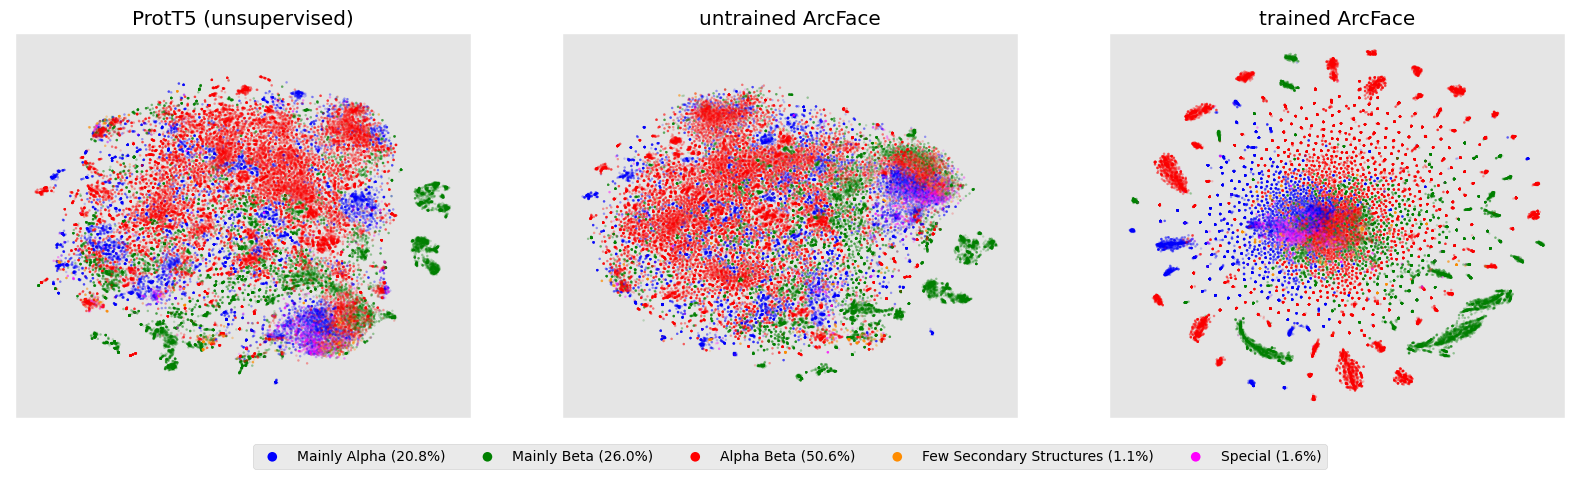

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=[20, 5])


for ax, model, plotname in zip([ax1, ax2, ax3], ["prott5", "untrained", "trained"], ["ProtT5 (unsupervised)", "untrained ArcFace", "trained ArcFace"]):
  for class_num, class_name, color in zip(
      [1, 2, 3, 4, 6],
      ["Mainly Alpha", "Mainly Beta", "Alpha Beta", "Few Secondary Structures", "Special"],
      ["blue", "green", "red", "darkorange", "fuchsia"]
  ):
    indices = [i for i in range(len(labels)) if int(labels[i]["C"]) == class_num]
    proportion = len(indices) / len(labels)

    data = np.take(tsne_results[model], indices, axis=0)
    ax.scatter(data[:, 0], data[:, 1], c=color, label=f"{class_name} ({proportion*100:.1f}%)", alpha=0.2, edgecolors="none", s=3)

    ax.set_title(plotname)

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

leg = ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=5, markerscale=4)
for lh in leg.legendHandles:
  lh.set_alpha(1)

#plt.tight_layout()
plt.savefig(get_base_dir() / "src/gobi_cath_classification/contrastive_learning_arcface/tsne.png", dpi=300)

In [ ]:
ma_indices = [i for i in range(len(labels)) if int(labels[i]["C"]) == 1]
ma = data = np.take(tsne_results["trained"], ma_indices, axis=0)
labels[np.where(tsne_results["trained"] == ma[:, 1].max())[0][0]]

1.10.8.1240

In [ ]:
!pip install --force-reinstall typing_extensions==3.10.0.2

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
pytorch-lightning 1.6.0 requires typing-extensions>=4.0.0, but you have typing-extensions 3.10.0.2 which is incompatible.


### Evaluation on Test/Holdout Set

In [14]:
dataset = load_data(
  ROOT_DIR / "data",
  rng=np.random.RandomState(42),
  without_duplicates=False,
  load_tmp_holdout_set=True,
  load_lookup_set=True,
  shuffle_data=False,
  load_only_small_sample=False,
  reloading_allowed=True,
  encode_labels=True,
)

lookup_data = dataset.get_split("lookup", "embedding-tensor", False, "tensor")

Loading data from directory: /content/drive/MyDrive/Files/Projects/University/2021W/GoBi/Project/gobi-2022-rost-cath-classification/data
Trying to find a serialized dataset ...
Found a serialized dataset to save time


In [15]:
import torch
from tqdm import tqdm

lookup_embeddings = torch.Tensor().type(torch.float32).to(model.device)
for x in tqdm(torch.split(lookup_data[0].type(torch.float32).to(model.device), 64)):
  emb = model(x)
  lookup_embeddings = torch.cat([lookup_embeddings, emb])

model.lookup_embeddings = lookup_embeddings

model.lookup_labels = lookup_data[1].to(model.device).type(torch.int64)
model.num_classes = len(dataset.all_labels)
model.label_encoder = dataset.label_encoder

100%|██████████| 1215/1215 [00:00<00:00, 3996.34it/s]


In [16]:
pred_test = model.predict(dataset.get_split("test", "embedding-tensor", False, "tensor")[0])
pred_holdout = model.predict(dataset.get_split("tmp_holdout", "embedding-tensor", False, "tensor")[0])

In [17]:
from gobi_cath_classification.pipeline.Evaluation import Evaluation
from gobi_cath_classification.pipeline.utils import CATHLabel

_, lookup_labels = dataset.get_split("train", x_encoding="embedding-tensor", zipped=False)

_, test_query_labels = dataset.get_split("test", x_encoding="embedding-tensor", zipped=False)

_, holdout_query_labels = dataset.get_split("tmp_holdout", x_encoding="embedding-tensor", zipped=False)

test_eval = Evaluation(
    [CATHLabel(label) for label in dataset.label_encoder.inverse_transform(test_query_labels)],
    pred_test,
    [CATHLabel(label) for label in dataset.label_encoder.inverse_transform(lookup_labels)],
    "ArcFace"
)

holdout_eval = Evaluation(
    [CATHLabel(label) for label in dataset.label_encoder.inverse_transform(holdout_query_labels)],
    pred_holdout,
    [CATHLabel(label) for label in dataset.label_encoder.inverse_transform(lookup_labels)],
    "ArcFace"
)

In [18]:
holdout_eval.compute_metrics(True)
holdout_eval.compute_std_err(bootstrap_n=10)
holdout_eval.print_evaluation()

100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


##################### EVALUATION RESULTS #####################

ArcFace: accuracy with errors
+---------+--------------+---------------+---------------+---------------+----------------+
|         | accuracy_c   | accuracy_a    | accuracy_t    | accuracy_h    | accuracy_avg   |
|---------+--------------+---------------+---------------+---------------+----------------|
| ArcFace | 0.9 +/- 0.04 | 0.86 +/- 0.04 | 0.84 +/- 0.05 | 0.82 +/- 0.05 | 0.86 +/- 0.05  |
+---------+--------------+---------------+---------------+---------------+----------------+

##################### EVALUATION RESULTS #####################



In [19]:
test_eval.compute_metrics(True)
test_eval.compute_std_err(bootstrap_n=10)
test_eval.print_evaluation()

100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


##################### EVALUATION RESULTS #####################

ArcFace: accuracy with errors
+---------+---------------+---------------+---------------+---------------+----------------+
|         | accuracy_c    | accuracy_a    | accuracy_t    | accuracy_h    | accuracy_avg   |
|---------+---------------+---------------+---------------+---------------+----------------|
| ArcFace | 0.83 +/- 0.07 | 0.68 +/- 0.08 | 0.61 +/- 0.07 | 0.71 +/- 0.08 | 0.71 +/- 0.06  |
+---------+---------------+---------------+---------------+---------------+----------------+

##################### EVALUATION RESULTS #####################

